### Dataframe de ejemplo para el treemap

In [2]:
from pathlib import Path
import pandas as pd

# Ruta relativa para el archivo Excel
input_dir = Path("input")
archivo_excel = input_dir / "HDs2025 (07-04-2025).xlsx"

xls = pd.ExcelFile(archivo_excel)
df = xls.parse("PLANTILLA")

# Ajustar encabezados
df.columns = df.iloc[0]
df = df[1:]

df['NUMERO DE VICTIMAS'] = pd.to_numeric(df['NUMERO DE VICTIMAS'], errors='coerce')
victimas_por_entidad = df.groupby('ENTIDAD FEDERATIVA')['NUMERO DE VICTIMAS'].sum().sort_values(ascending=False)
victimas_por_entidad

ENTIDAD FEDERATIVA
GUANAJUATO                         869
ESTADO DE MEXICO                   485
BAJA CALIFORNIA                    432
SINALOA                            407
CHIHUAHUA                          385
MICHOACAN DE OCAMPO                379
SONORA                             342
JALISCO                            308
MORELOS                            283
TABASCO                            272
NUEVO LEON                         258
GUERRERO                           239
CIUDAD DE MEXICO                   224
VERACRUZ DE IGNACIO DE LA LLAVE    220
PUEBLA                             175
OAXACA                             168
QUINTANA ROO                       119
CHIAPAS                            114
COLIMA                             111
SAN LUIS POTOSI                     91
TAMAULIPAS                          77
ZACATECAS                           69
HIDALGO                             60
NAYARIT                             46
TLAXCALA                            32
CAMPEC

### **Código a copiar para el treemap:**

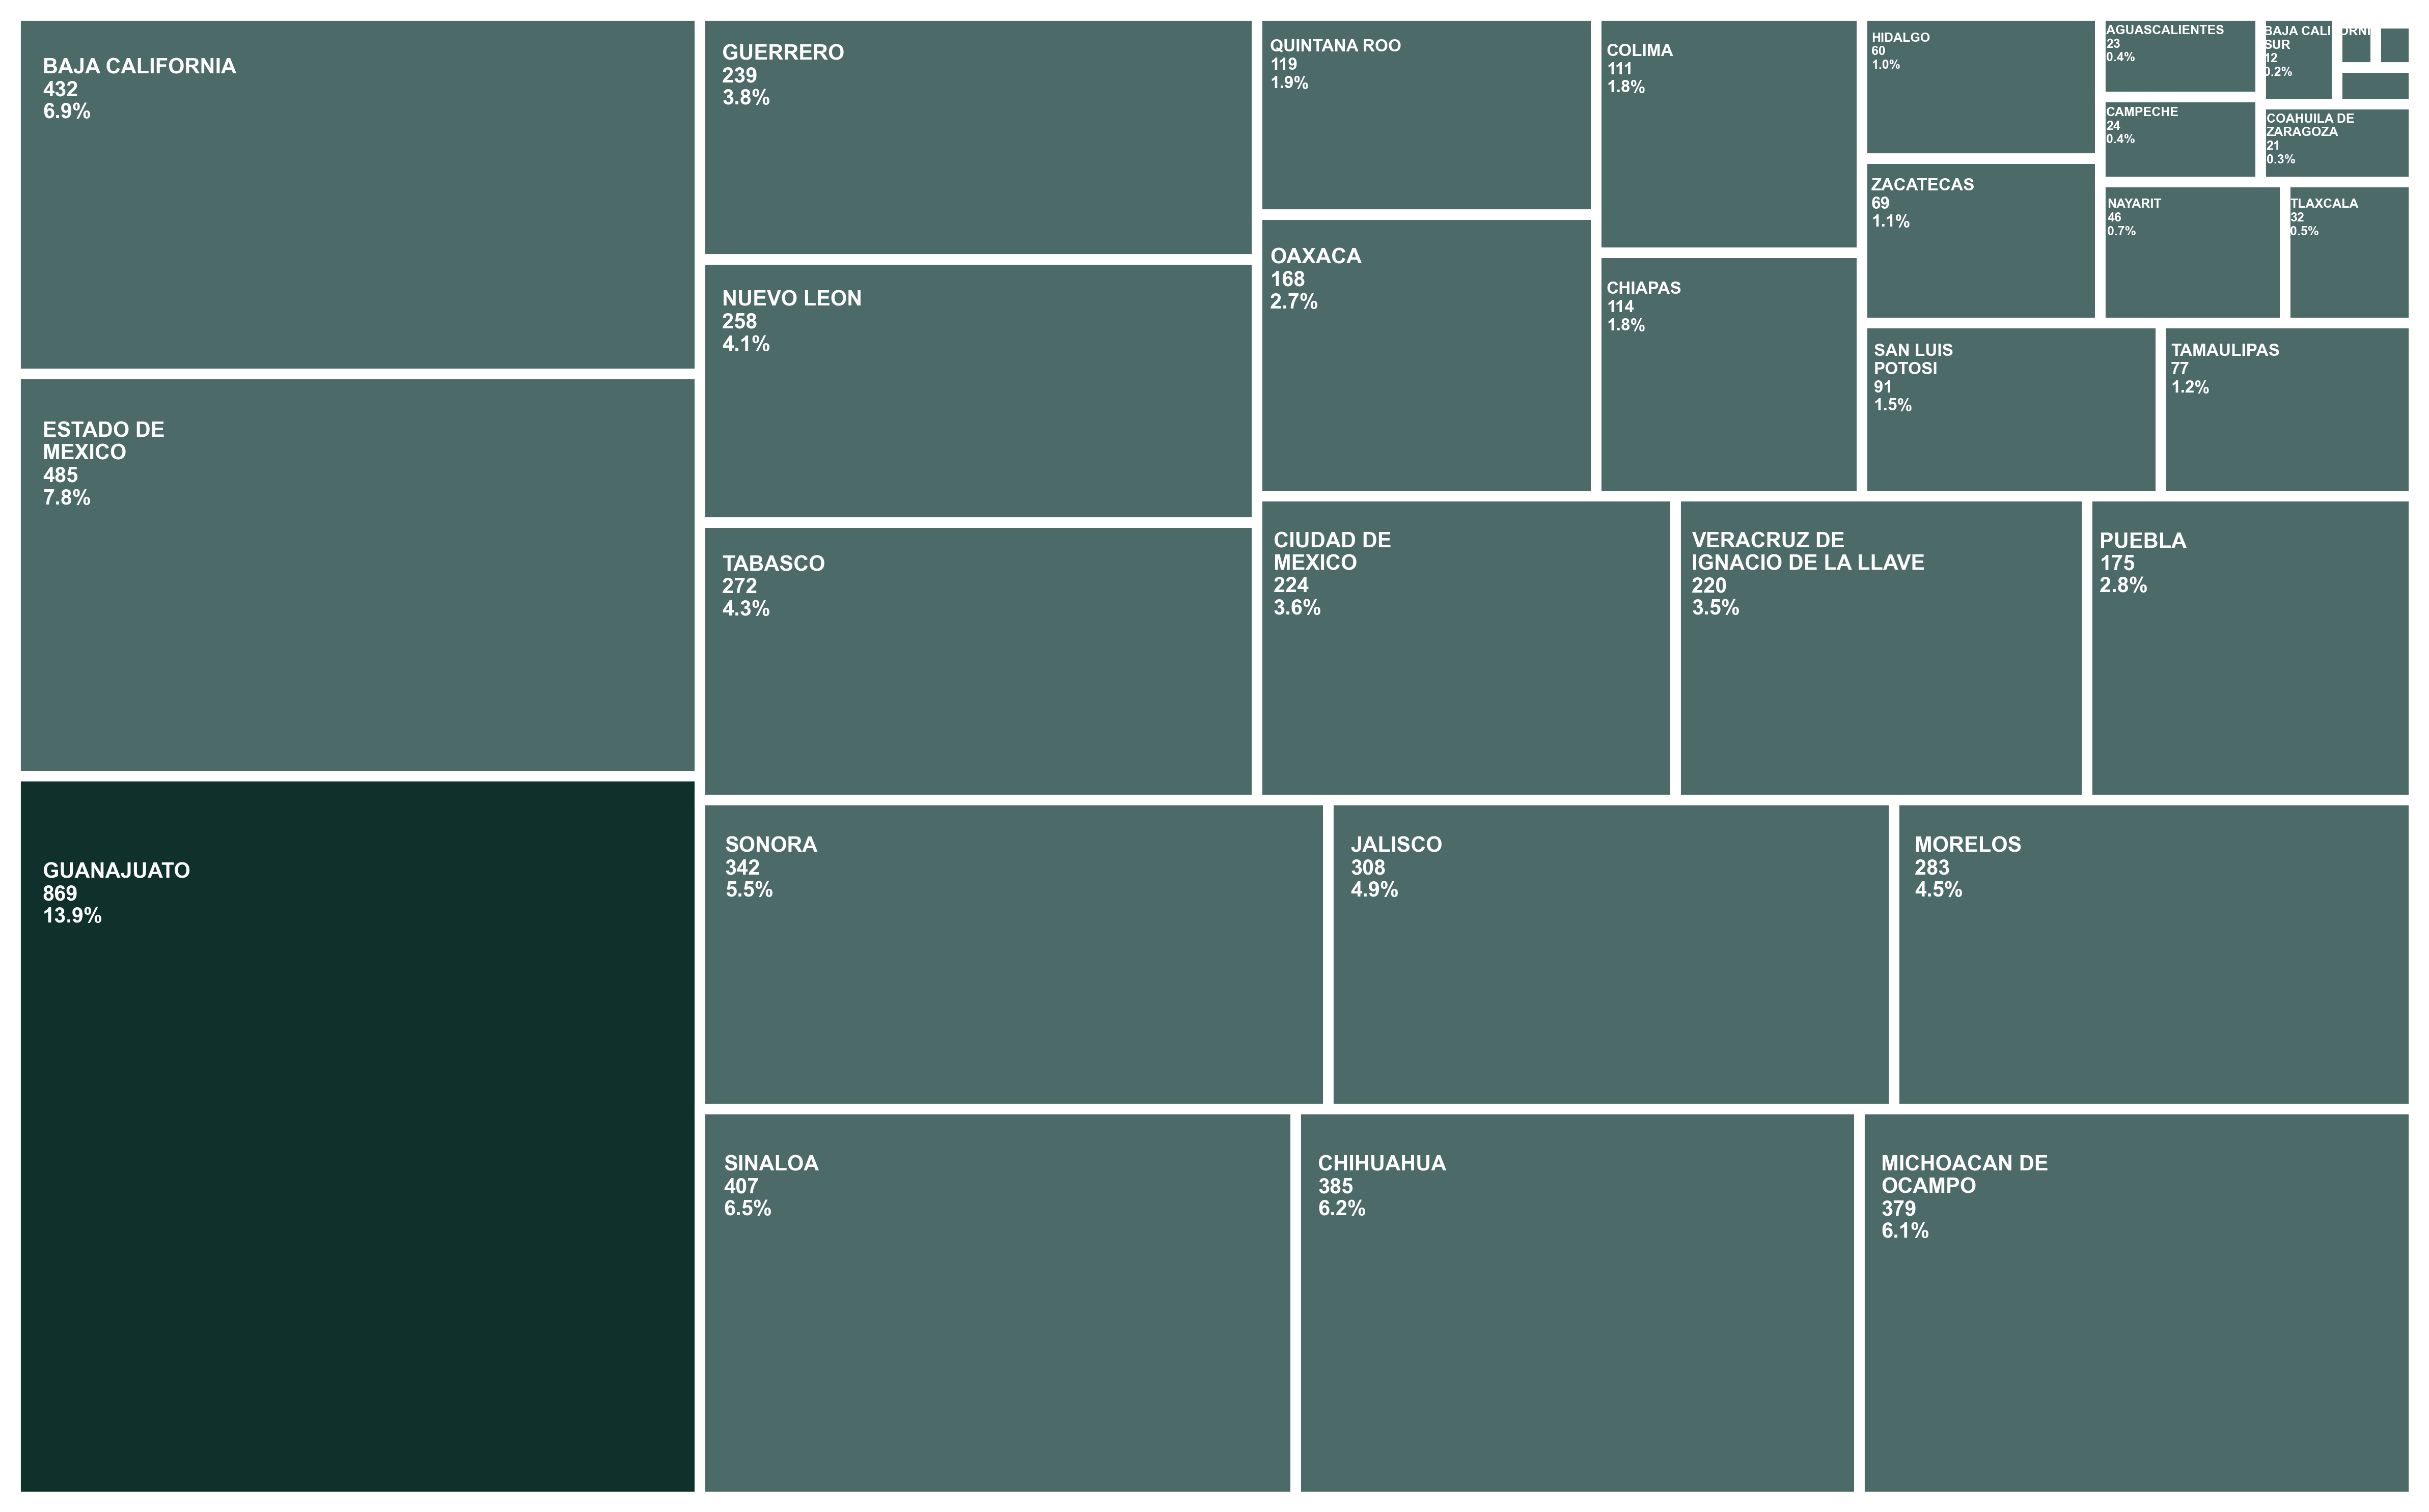

In [7]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import squarify 

# VARIABLES A CAMBIAR:
dataframe_a_graficar = victimas_por_entidad

# Configurar las fuentes SVG como texto editable
plt.rcParams['svg.fonttype'] = 'none'

# Ruta relativa para las fuentes
font_dirs = [Path("fonts/arial")]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Crear una instancia de FontProperties para Arial
arial_font = font_manager.FontProperties(fname=str(font_files[0]))


def treemap(victimas_por_entidad):
    if not isinstance(victimas_por_entidad, pd.Series):
        raise ValueError("Los datos deben ser una Serie de pandas")

    # Asegurar que todos los valores sean numéricos tipo float
    victimas_por_entidad = pd.to_numeric(victimas_por_entidad, errors='coerce').fillna(0).astype(float)

    # Configuración de fuentes y colores
    font_config = {
        'family': 'Arial',
        'titulo': {'size': 18, 'weight': 'bold', 'color': '#10302C'},
        'etiquetas': {'size': 10, 'weight': 'bold', 'color': 'white'},
        'porcentaje': {'size': 9, 'weight': 'medium', 'color': '#A57F2C'}
    }

    try:
        # Crear dataframe desde la serie
        df = pd.DataFrame({
            'ENTIDAD': victimas_por_entidad.index,
            'Total': victimas_por_entidad.values
        })
        df.set_index('ENTIDAD', inplace=True)

        # Ordenar y calcular porcentaje
        df = df.sort_values(by='Total', ascending=False)
        total_nacional = df['Total'].sum()
        df['Porcentaje'] = (df['Total'] / total_nacional * 100).round(1)
    except Exception as e:
        print(f"Error: {e}")
        return None

    # Colores
    max_valor = df['Total'].max()
    colores = ['#10302C' if val == max_valor else '#4C6A67' for val in df['Total']]

    # Configurar la figura
    plt.rc('font', family=font_config['family'])
    fig, ax = plt.subplots(figsize=(16, 10), dpi=300)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # rectangulos
    sizes = df['Total'].tolist()
    rectangles = squarify.normalize_sizes(sizes, 1, 1)
    rectangles = squarify.squarify(rectangles, 0, 0, 1, 1)

    for rect, (entidad, row), color in zip(rectangles, df.iterrows(), colores):
        x, y, dx, dy = rect['x'], rect['y'], rect['dx'], rect['dy']

        ax.add_patch(plt.Rectangle(
            (x, y), dx, dy,
            facecolor=color,
            edgecolor='white',
            linewidth=5
        ))

        area = dx * dy

        if area > 0.001:
            palabras = entidad.split()
            if len(palabras) > 2:
                entidad_mod = ' '.join(palabras[:2]) + '\n' + ' '.join(palabras[2:])
            else:
                entidad_mod = entidad

            etiqueta = f"{entidad_mod}\n{int(row['Total']):,}\n{row['Porcentaje']}%"

            # Ajuste automático de tamaño de fuente según área
            if area > 0.02:
                fontsize = 10
            elif area > 0.01:
                fontsize = 8
            else:
                fontsize = 6

            x_text = x + dx * 0.04
            y_text = y + dy * 0.88

            ax.text(
                x_text,
                y_text,
                etiqueta,
                ha='left',
                va='top',
                fontsize=fontsize,
                fontweight=font_config['etiquetas']['weight'],
                color=font_config['etiquetas']['color'],
                zorder=10
            )

    ax.axis('off')

    plt.tight_layout()

    # Guardar la gráfica como archivo SVG
    plt.savefig("treemap.svg", format="svg", bbox_inches='tight')
    plt.show()

treemap(dataframe_a_graficar)